In [1]:
import geopandas
import urllib
import pandas
from datetime import date
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import contextily
import re

In [2]:
import fiona;
fiona.supported_drivers


{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [3]:
# mapping_crs = "EPSG:3347" # NAD83 / Statistics Canada Lambert
mapping_crs = "EPSG:3857" # Pseudo-Mercator
output_crs = "EPSG:4326" # Lat/Lng https://epsg.io/4326

In [131]:
def load_geodataset(remote_path, local_path, refresh_cache=False):
    df = None
    if not refresh_cache:
        try:
            df = geopandas.read_file(local_path)
        except Exception as e:
            print(e)
    
    if df is None:
        print(f"Loading {remote_path}")
        df = geopandas.read_file(remote_path)

        print(f"Saving to {local_path}")
        df.to_file(local_path)

    return df

In [132]:
def get_vancouver_bike_map(refresh_cache=False):
    # Get City of Vancouver's bikeways dataset https://opendata.vancouver.ca/explore/dataset/bikeways/
    remote_path = "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/bikeways/exports/geojson?lang=en&timezone=America%2FLos_Angeles"
    local_path = "data/bikeways.geojson"
    return load_geodataset(remote_path, local_path, refresh_cache=refresh_cache)


In [133]:
pandas.set_option('display.max_columns', None)

In [134]:
vancouver_bike_map = get_vancouver_bike_map()
vancouver_bike_map

,object_id,bike_route_name,street_name,bikeway_type,subtype,status,street_segment_type,overall_direction,bikeway_direction,vehicle_direction,speed_limit,surface_type,aaa_network,aaa_segment,w_n_bound_type,e_s_bound_type,snow_removal,segment_length,year_of_construction,construction_note,upgrade_year,notes,geo_point_2d,geometry
0,306226,Alexander,Alexander,Local Street,NaN,Active,Residential,EW,CFlow,OW,30.0,Paved,YES,YES,Local Street,Local Street,Yes,159.729476,2018,NaN,NaN,NaN,"{'lon': -123.10320658901507, 'lat': 49.2835810...","LINESTRING (-123.10426 49.28350, -123.10394 49..."
1,306228,Cardero,Cardero,Shared Lanes,NaN,Active,Arterial,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,36.334538,2006,NaN,NaN,NaN,"{'lon': -123.13140195000565, 'lat': 49.2900285...","LINESTRING (-123.13123 49.29014, -123.13158 49..."
2,306235,Ontario,Ontario,Local Street,NaN,Active,Residential,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,53.071079,1995,year const- Peter Stary,NaN,NaN,"{'lon': -123.10649770440874, 'lat': 49.2131066...","LINESTRING (-123.10648 49.21335, -123.10651 49..."
3,306236,Stanley Park,Stanley Park Causeway,Painted Lanes,NB,Active,Arterial,EW,2W,2W,50.0,Paved,NO,NO,Painted Lanes,Painted Lanes,No,40.185599,2009,"pre-2009, e- side on sidewalk not paint",NaN,NaN,"{'lon': -123.13675610584146, 'lat': 49.2946783...","LINESTRING (-123.13680 49.29486, -123.13679 49..."
4,306238,Ridgeway,W 18th Ave,Local Street,NaN,Active,Residential,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,82.766861,2013,NaN,NaN,NaN,"{'lon': -123.18745762559382, 'lat': 49.2564926...","LINESTRING (-123.18803 49.25649, -123.18689 49..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,309373,King Edward,W King Edward,Painted Lanes,PBP,Active,Arterial,EW,2W,2W,50.0,Paved,NO,NO,Painted Lanes,Painted Lanes,Yes,128.416415,2015,NaN,NaN,NaN,"{'lon': -123.1585301499966, 'lat': 49.25007090...","LINESTRING (-123.15777 49.25037, -123.15929 49..."
3662,309375,King Edward,W King Edward,Painted Lanes,PBP,Active,Arterial,EW,2W,2W,50.0,Paved,NO,NO,Painted Lanes,Painted Lanes,Yes,20.565271,2015,NaN,NaN,NaN,"{'lon': -123.15589310578144, 'lat': 49.2510971...","LINESTRING (-123.15577 49.25114, -123.15601 49..."
3663,309379,Bute,Bute,Local Street,NaN,Active,Residential,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,55.016173,2018,NaN,NaN,NaN,"{'lon': -123.13149854700721, 'lat': 49.2830145...","LINESTRING (-123.13123 49.28319, -123.13176 49..."
3664,309381,Off-Broadway,E 8th Ave,Local Street,NaN,Active,Residential,EW,2W,2W,50.0,Paved,NO,NO,Local Street,Local Street,No,155.623243,1997,year const-source unknown,NaN,NaN,"{'lon': -123.066946189811, 'lat': 49.263246312...","LINESTRING (-123.06802 49.26325, -123.06794 49..."


In [135]:
def calc_removed_year(row):
    if row["status"] == "Legacy":
        m = re.search(r"Removed in (\d{4})", row["notes"])
        if m:
            return int(m.group(1))
    return np.NaN


In [136]:
vancouver_bike_map["year_removed"] = vancouver_bike_map.apply(calc_removed_year, axis=1)

In [139]:
vancouver_bike_map = vancouver_bike_map[~vancouver_bike_map["year_of_construction"].isna()]
vancouver_bike_map = vancouver_bike_map.astype({"year_of_construction": "float", "upgrade_year": "float"})


<Axes: >

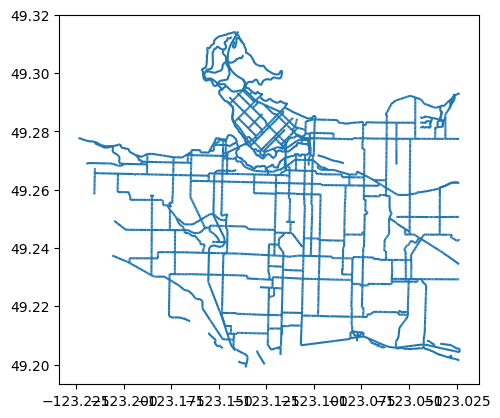

In [140]:
vancouver_bike_map.plot()

In [141]:
vancouver_bike_map = vancouver_bike_map.to_crs(mapping_crs)

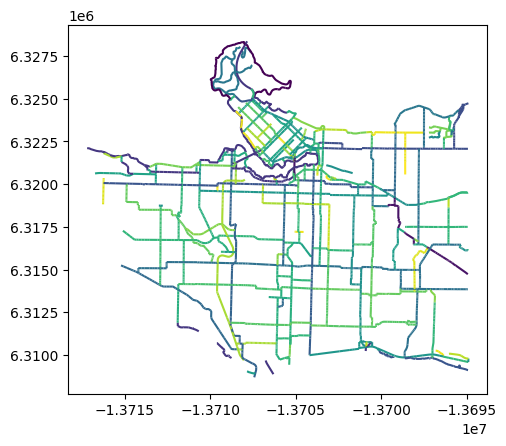

In [142]:
full_map = vancouver_bike_map.plot(column="year_of_construction")

In [143]:
contextily.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<insert 

In [152]:
def draw_map(bike_map, filename, subtitle=None, color_by=None, title="Vancouver Bike Map"):
    ax = bike_map.plot(figsize=(10, 10), column=color_by)
    ax.set_xlim(full_map.get_xlim())
    ax.set_ylim(full_map.get_ylim())
    ax.set_axis_off()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    plt.title(subtitle,fontsize=18, y=1)
    plt.suptitle(title,fontsize=30, y=0.95)
    contextily.add_basemap(ax, source=contextily.providers.CartoDB.Voyager)
    
    ax.get_figure().savefig(filename)
    plt.close('all')


In [127]:
draw_map(vancouver_bike_map, f"output/all.png", subtitle="all")

In [155]:
def filter_bike_map(year):
    # Figure out of the bike lane as AAA in this year
    def calc_current_status(row):
        if row["aaa_segment"] == "YES" and not (year < row["upgrade_year"]):
            return "AAA"
        return "standard"
    vancouver_bike_map["current_type"] = vancouver_bike_map.apply(calc_current_status, axis=1)

    filtered = vancouver_bike_map[(year >= vancouver_bike_map["year_of_construction"]) & ~(year >= vancouver_bike_map["year_removed"])]
    return filtered

In [148]:
min_year = int(min(vancouver_bike_map["year_of_construction"]))
max_year = date.today().year

<Axes: xlabel='year'>

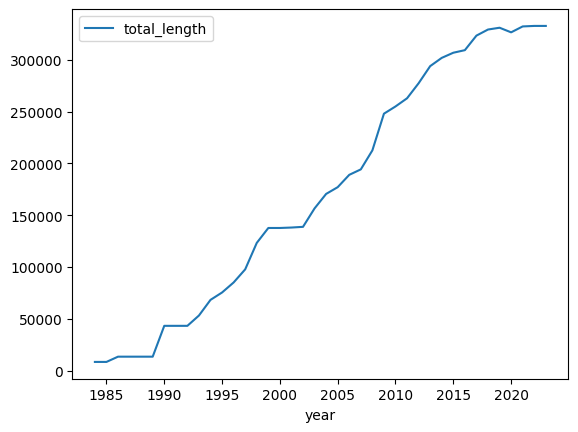

In [149]:
bikeway_summary_by_year = []
for year in range(min_year, max_year+1):
    bikeway_summary_by_year.append({
        "year": year,
        "total_length": filter_bike_map(year)["segment_length"].sum()
    })
bikeway_summary_by_year = pandas.DataFrame(bikeway_summary_by_year).set_index("year")
bikeway_summary_by_year.plot()

In [154]:
filter_bike_map(2023)

,object_id,bike_route_name,street_name,bikeway_type,subtype,status,street_segment_type,overall_direction,bikeway_direction,vehicle_direction,speed_limit,surface_type,aaa_network,aaa_segment,w_n_bound_type,e_s_bound_type,snow_removal,segment_length,year_of_construction,construction_note,upgrade_year,notes,geo_point_2d,geometry,year_removed,current_type
0,306226,Alexander,Alexander,Local Street,NaN,Active,Residential,EW,CFlow,OW,30.0,Paved,YES,YES,Local Street,Local Street,Yes,159.729476,2018.0,NaN,NaN,NaN,"{'lon': -123.10320658901507, 'lat': 49.2835810...","LINESTRING (-13703903.734 6323102.469, -137038...",NaN,AA
1,306228,Cardero,Cardero,Shared Lanes,NaN,Active,Arterial,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,36.334538,2006.0,NaN,NaN,NaN,"{'lon': -123.13140195000565, 'lat': 49.2900285...","LINESTRING (-13706905.389 6324237.035, -137069...",NaN,standard
2,306235,Ontario,Ontario,Local Street,NaN,Active,Residential,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,53.071079,1995.0,year const- Peter Stary,NaN,NaN,"{'lon': -123.10649770440874, 'lat': 49.2131066...","LINESTRING (-13704150.881 6311139.439, -137041...",NaN,standard
3,306236,Stanley Park,Stanley Park Causeway,Painted Lanes,NB,Active,Arterial,EW,2W,2W,50.0,Paved,NO,NO,Painted Lanes,Painted Lanes,No,40.185599,2009.0,"pre-2009, e- side on sidewalk not paint",NaN,NaN,"{'lon': -123.13675610584146, 'lat': 49.2946783...","LINESTRING (-13707525.400 6325041.655, -137075...",NaN,standard
4,306238,Ridgeway,W 18th Ave,Local Street,NaN,Active,Residential,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,82.766861,2013.0,NaN,NaN,NaN,"{'lon': -123.18745762559382, 'lat': 49.2564926...","LINESTRING (-13713228.363 6318495.792, -137131...",NaN,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,309373,King Edward,W King Edward,Painted Lanes,PBP,Active,Arterial,EW,2W,2W,50.0,Paved,NO,NO,Painted Lanes,Painted Lanes,Yes,128.416415,2015.0,NaN,NaN,NaN,"{'lon': -123.1585301499966, 'lat': 49.25007090...","LINESTRING (-13709860.444 6317450.548, -137100...",NaN,standard
3662,309375,King Edward,W King Edward,Painted Lanes,PBP,Active,Arterial,EW,2W,2W,50.0,Paved,NO,NO,Painted Lanes,Painted Lanes,Yes,20.565271,2015.0,NaN,NaN,NaN,"{'lon': -123.15589310578144, 'lat': 49.2510971...","LINESTRING (-13709637.790 6317583.295, -137096...",NaN,standard
3663,309379,Bute,Bute,Local Street,NaN,Active,Residential,NS,2W,2W,30.0,Paved,NO,NO,Local Street,Local Street,No,55.016173,2018.0,NaN,NaN,NaN,"{'lon': -123.13149854700721, 'lat': 49.2830145...","LINESTRING (-13706906.117 6323050.223, -137069...",NaN,standard
3664,309381,Off-Broadway,E 8th Ave,Local Street,NaN,Active,Residential,EW,2W,2W,50.0,Paved,NO,NO,Local Street,Local Street,No,155.623243,1997.0,year const-source unknown,NaN,NaN,"{'lon': -123.066946189811, 'lat': 49.263246312...","LINESTRING (-13699868.830 6319648.775, -136998...",NaN,standard


In [156]:
for year in range(min_year, max_year+1):
    print(year)
    filtered = filter_bike_map(year)
    draw_map(filtered, f"output/vancouver_bike_map_{year}.png", subtitle=str(year), color_by="current_type")



1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
